## 1. Import Required Libraries

In [1]:
# Standard library
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO

# Configure visualization
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Configuration and Setup

In [2]:
# Define paths
PROJECT_ROOT = Path("..").resolve()
MODEL_PATH = PROJECT_ROOT / "weights" / "localization" / "best.pt"
TEST_IMAGES_DIR = (
    PROJECT_ROOT / "data" / "processed" / "localization" / "images" / "test"
)
OUTPUT_DIR = PROJECT_ROOT / "data" / "interim"

# Create output directory if not exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify paths
assert MODEL_PATH.exists(), f"Model not found: {MODEL_PATH}"
assert TEST_IMAGES_DIR.exists(), f"Test directory not found: {TEST_IMAGES_DIR}"

print(f"📂 Project Root: {PROJECT_ROOT}")
print(f"🤖 Model Path: {MODEL_PATH}")
print(f"🖼️  Test Images: {TEST_IMAGES_DIR}")
print(f"💾 Output Directory: {OUTPUT_DIR}")

📂 Project Root: E:\container-id-research
🤖 Model Path: E:\container-id-research\weights\localization\best.pt
🖼️  Test Images: E:\container-id-research\data\processed\localization\images\test
💾 Output Directory: E:\container-id-research\data\interim


## 3. Load YOLOv11-Pose Model

In [3]:
# Load model
model = YOLO(str(MODEL_PATH))

print(f"✅ Model loaded successfully")
print(f"Model type: {model.task}")
print(
    f"Number of keypoints: {model.model.model[-1].kpt_shape[0] if hasattr(model.model.model[-1], 'kpt_shape') else 'N/A'}"
)

✅ Model loaded successfully
Model type: pose
Number of keypoints: 4


## 4. Helper Functions for Geometric Calculations

In [4]:
def euclidean_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    """
    Calculate Euclidean distance between two points.

    Args:
        p1: First point [x, y]
        p2: Second point [x, y]

    Returns:
        Distance as float
    """
    return np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def calculate_bbox_dimensions(keypoints: np.ndarray) -> Tuple[float, float, float]:
    """
    Calculate width, height, and aspect ratio from 4 keypoints.

    Keypoint Order Assumption: [Top-Left, Top-Right, Bottom-Right, Bottom-Left]

    Args:
        keypoints: Array of shape (4, 2) containing [x, y] coordinates

    Returns:
        Tuple of (width, height, aspect_ratio)
    """
    # Ensure keypoints have correct shape
    assert keypoints.shape == (4, 2), f"Expected (4, 2) shape, got {keypoints.shape}"

    # Extract keypoints
    tl, tr, br, bl = keypoints[0], keypoints[1], keypoints[2], keypoints[3]

    # Calculate edge lengths
    top_edge = euclidean_distance(tl, tr)
    bottom_edge = euclidean_distance(bl, br)
    left_edge = euclidean_distance(tl, bl)
    right_edge = euclidean_distance(tr, br)

    # Width = max of top and bottom edges
    width = max(top_edge, bottom_edge)

    # Height = max of left and right edges
    height = max(left_edge, right_edge)

    # Aspect Ratio = Width / Height
    aspect_ratio = width / height if height > 0 else 0.0

    return width, height, aspect_ratio


print("✅ Helper functions defined")

✅ Helper functions defined


## 5. Run Inference and Extract Geometric Data

In [5]:
# Get all test images
test_images = sorted(
    list(TEST_IMAGES_DIR.glob("*.jpg")) + list(TEST_IMAGES_DIR.glob("*.png"))
)

print(f"📊 Found {len(test_images)} test images")

# Storage for results
results_data: List[Dict] = []

# Process each image
for idx, image_path in enumerate(test_images, 1):
    # Run inference
    results = model(str(image_path), verbose=False)

    # Extract the best prediction (highest confidence)
    if len(results) > 0 and results[0].keypoints is not None:
        # Get keypoints data
        keypoints_data = results[
            0
        ].keypoints.data  # Shape: (num_detections, num_keypoints, 3)

        if len(keypoints_data) > 0:
            # Get confidence scores from boxes
            confidences = results[0].boxes.conf.cpu().numpy()

            # Find index of highest confidence detection
            best_idx = np.argmax(confidences)
            best_conf = float(confidences[best_idx])

            # Extract keypoints for best detection (x, y coordinates only)
            best_keypoints = (
                keypoints_data[best_idx, :, :2].cpu().numpy()
            )  # Shape: (4, 2)

            # Calculate geometric properties
            try:
                width, height, aspect_ratio = calculate_bbox_dimensions(best_keypoints)

                # Store results
                results_data.append(
                    {
                        "filename": image_path.name,
                        "confidence": best_conf,
                        "width": width,
                        "height": height,
                        "aspect_ratio": aspect_ratio,
                    }
                )

            except Exception as e:
                print(f"⚠️  Error processing {image_path.name}: {e}")

    # Progress indicator
    if idx % 10 == 0:
        print(f"Processed {idx}/{len(test_images)} images...")

print(f"\n✅ Inference complete! Processed {len(results_data)} images successfully.")

📊 Found 76 test images
Processed 10/76 images...
Processed 20/76 images...
Processed 30/76 images...
Processed 40/76 images...
Processed 50/76 images...
Processed 60/76 images...
Processed 70/76 images...

✅ Inference complete! Processed 76 images successfully.


## 6. Create DataFrame and Save Results

In [6]:
# Create DataFrame
df = pd.DataFrame(results_data)

# Save to CSV
output_csv = OUTPUT_DIR / "geometric_check_report.csv"
df.to_csv(output_csv, index=False)

print(f"💾 Results saved to: {output_csv}")
print(f"\n📊 Dataset Summary:")
print(f"Total samples: {len(df)}")
print(f"\nFirst 5 rows:")
display(df.head())

💾 Results saved to: E:\container-id-research\data\interim\geometric_check_report.csv

📊 Dataset Summary:
Total samples: 76

First 5 rows:


,filename,confidence,width,height,aspect_ratio
0,0000088.jpg,0.678025,408.921509,55.540916,7.362527
1,0000155.jpg,0.635241,431.057739,54.682682,7.882893
2,0000433.jpg,0.758144,393.332642,52.205486,7.534316
3,0000588.jpg,0.533103,322.052765,42.105495,7.648711
4,0000812.jpg,0.635076,246.812637,32.006199,7.711401


## 7. Statistical Analysis

In [7]:
# Calculate descriptive statistics
stats = df["aspect_ratio"].describe()

# Calculate percentiles for threshold recommendation
p1 = df["aspect_ratio"].quantile(0.01)
p99 = df["aspect_ratio"].quantile(0.99)

print("=" * 60)
print("ASPECT RATIO STATISTICAL SUMMARY")
print("=" * 60)
print(f"\n📊 Descriptive Statistics:")
print(f"  Mean:     {stats['mean']:.4f}")
print(f"  Median:   {stats['50%']:.4f}")
print(f"  Std Dev:  {stats['std']:.4f}")
print(f"  Min:      {stats['min']:.4f}")
print(f"  Max:      {stats['max']:.4f}")

print(f"\n🎯 Percentiles (for Threshold Determination):")
print(f"  1st Percentile (P1):   {p1:.4f}")
print(f"  5th Percentile (P5):   {df['aspect_ratio'].quantile(0.05):.4f}")
print(f"  25th Percentile (Q1):  {stats['25%']:.4f}")
print(f"  50th Percentile (Q2):  {stats['50%']:.4f}")
print(f"  75th Percentile (Q3):  {stats['75%']:.4f}")
print(f"  95th Percentile (P95): {df['aspect_ratio'].quantile(0.95):.4f}")
print(f"  99th Percentile (P99): {p99:.4f}")

print(f"\n" + "=" * 60)
print(f"🔍 RECOMMENDED THRESHOLDS")
print("=" * 60)
print(f"  MIN_AR_THRESHOLD (P1):  {p1:.4f}")
print(f"  MAX_AR_THRESHOLD (P99): {p99:.4f}")
print("=" * 60)

ASPECT RATIO STATISTICAL SUMMARY

📊 Descriptive Statistics:
  Mean:     7.3492
  Median:   7.4345
  Std Dev:  0.7668
  Min:      3.4078
  Max:      8.4732

🎯 Percentiles (for Threshold Determination):
  1st Percentile (P1):   5.4733
  5th Percentile (P5):   6.2607
  25th Percentile (Q1):  6.9942
  50th Percentile (Q2):  7.4345
  75th Percentile (Q3):  7.8413
  95th Percentile (P95): 8.3427
  99th Percentile (P99): 8.4114

🔍 RECOMMENDED THRESHOLDS
  MIN_AR_THRESHOLD (P1):  5.4733
  MAX_AR_THRESHOLD (P99): 8.4114


## 8. Visualization: Histogram

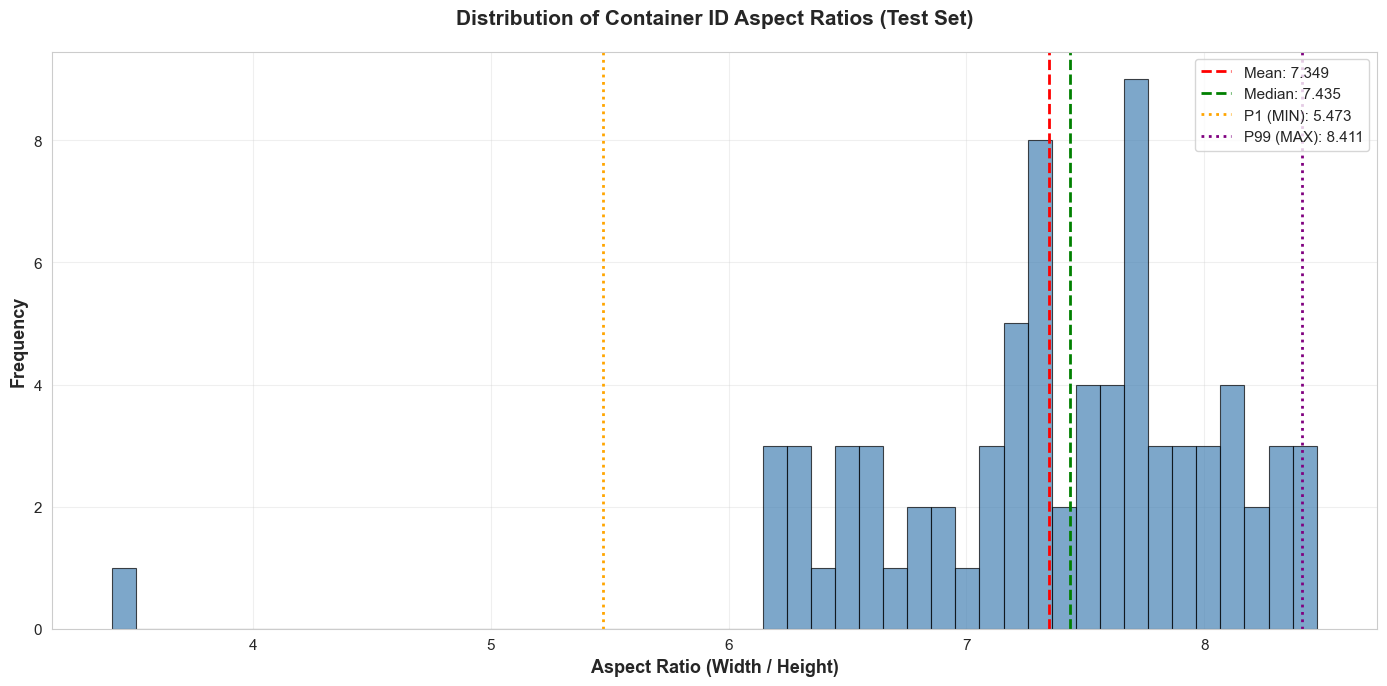

💾 Histogram saved to: E:\container-id-research\data\interim\aspect_ratio_histogram.png


In [8]:
# Create histogram
fig, ax = plt.subplots(figsize=(14, 7))

# Plot histogram
n, bins, patches = ax.hist(
    df["aspect_ratio"],
    bins=50,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.8,
)

# Add vertical lines for key statistics
ax.axvline(
    df["aspect_ratio"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['aspect_ratio'].mean():.3f}",
)
ax.axvline(
    df["aspect_ratio"].median(),
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['aspect_ratio'].median():.3f}",
)
ax.axvline(p1, color="orange", linestyle=":", linewidth=2, label=f"P1 (MIN): {p1:.3f}")
ax.axvline(
    p99, color="purple", linestyle=":", linewidth=2, label=f"P99 (MAX): {p99:.3f}"
)

# Labels and title
ax.set_xlabel("Aspect Ratio (Width / Height)", fontsize=13, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=13, fontweight="bold")
ax.set_title(
    "Distribution of Container ID Aspect Ratios (Test Set)",
    fontsize=15,
    fontweight="bold",
    pad=20,
)
ax.legend(fontsize=11, loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "aspect_ratio_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"💾 Histogram saved to: {OUTPUT_DIR / 'aspect_ratio_histogram.png'}")

## 9. Visualization: Boxplot

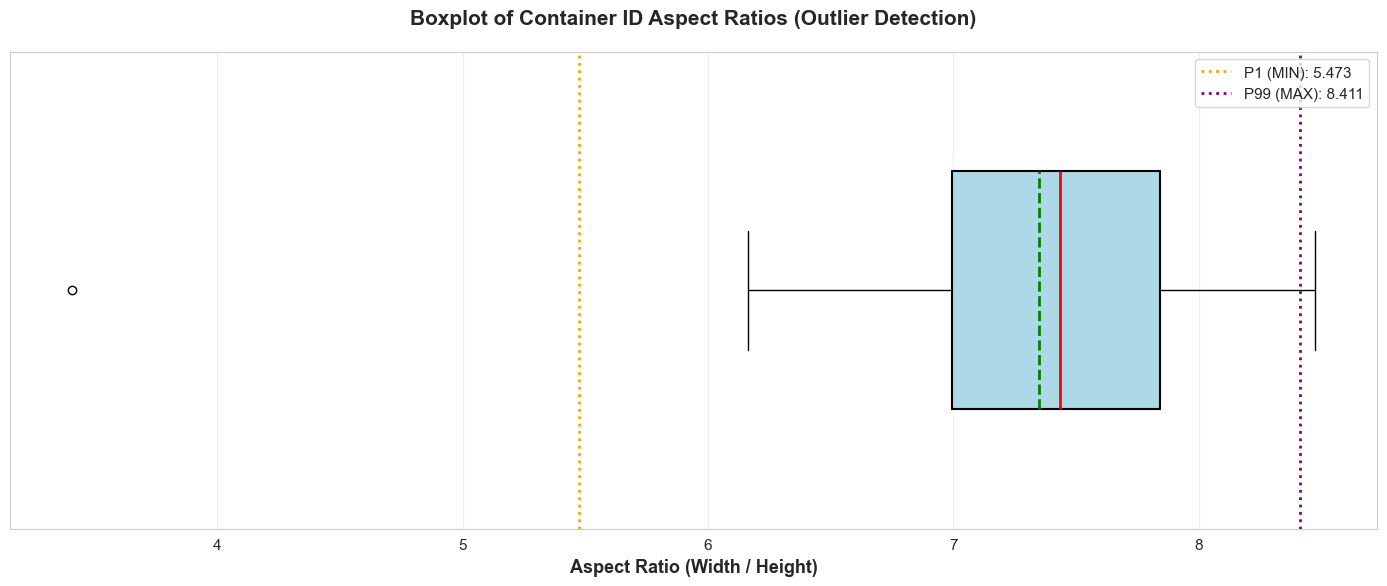

💾 Boxplot saved to: E:\container-id-research\data\interim\aspect_ratio_boxplot.png


In [9]:
# Create boxplot
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot
bp = ax.boxplot(
    df["aspect_ratio"],
    vert=False,
    patch_artist=True,
    widths=0.5,
    showmeans=True,
    meanline=True,
)

# Customize colors
bp["boxes"][0].set_facecolor("lightblue")
bp["boxes"][0].set_edgecolor("black")
bp["boxes"][0].set_linewidth(1.5)
bp["medians"][0].set_color("red")
bp["medians"][0].set_linewidth(2)
bp["means"][0].set_color("green")
bp["means"][0].set_linewidth(2)

# Add threshold lines
ax.axvline(p1, color="orange", linestyle=":", linewidth=2, label=f"P1 (MIN): {p1:.3f}")
ax.axvline(
    p99, color="purple", linestyle=":", linewidth=2, label=f"P99 (MAX): {p99:.3f}"
)

# Labels and title
ax.set_xlabel("Aspect Ratio (Width / Height)", fontsize=13, fontweight="bold")
ax.set_title(
    "Boxplot of Container ID Aspect Ratios (Outlier Detection)",
    fontsize=15,
    fontweight="bold",
    pad=20,
)
ax.legend(fontsize=11, loc="upper right")
ax.grid(True, alpha=0.3, axis="x")
ax.set_yticks([])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "aspect_ratio_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"💾 Boxplot saved to: {OUTPUT_DIR / 'aspect_ratio_boxplot.png'}")

## 10. Outlier Analysis

In [10]:
# Identify outliers using IQR method
Q1 = df["aspect_ratio"].quantile(0.25)
Q3 = df["aspect_ratio"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["aspect_ratio"] < lower_bound) | (df["aspect_ratio"] > upper_bound)]

print(f"📊 Outlier Analysis (IQR Method):")
print(f"  Q1: {Q1:.4f}")
print(f"  Q3: {Q3:.4f}")
print(f"  IQR: {IQR:.4f}")
print(f"  Lower Bound: {lower_bound:.4f}")
print(f"  Upper Bound: {upper_bound:.4f}")
print(f"\n🔴 Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0:
    print(f"\n⚠️  Outlier samples:")
    display(
        outliers[["filename", "confidence", "aspect_ratio"]].sort_values("aspect_ratio")
    )

📊 Outlier Analysis (IQR Method):
  Q1: 6.9942
  Q3: 7.8413
  IQR: 0.8472
  Lower Bound: 5.7234
  Upper Bound: 9.1121

🔴 Number of outliers: 1 (1.32%)

⚠️  Outlier samples:


,filename,confidence,aspect_ratio
70,0023666.jpg,0.88392,3.40783


## 11. Confidence vs Aspect Ratio Analysis

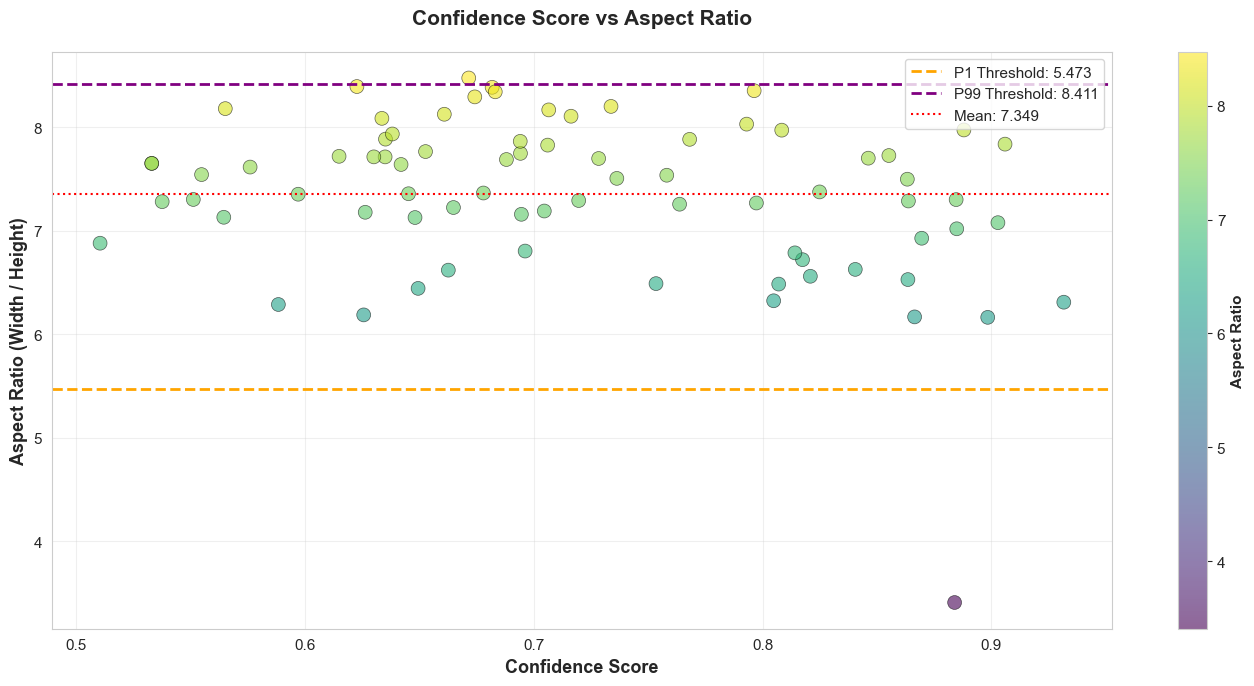

💾 Scatter plot saved to: E:\container-id-research\data\interim\confidence_vs_aspect_ratio.png


In [11]:
# Scatter plot: Confidence vs Aspect Ratio
fig, ax = plt.subplots(figsize=(14, 7))

scatter = ax.scatter(
    df["confidence"],
    df["aspect_ratio"],
    c=df["aspect_ratio"],
    cmap="viridis",
    s=100,
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5,
)

# Add threshold lines
ax.axhline(
    p1, color="orange", linestyle="--", linewidth=2, label=f"P1 Threshold: {p1:.3f}"
)
ax.axhline(
    p99, color="purple", linestyle="--", linewidth=2, label=f"P99 Threshold: {p99:.3f}"
)
ax.axhline(
    df["aspect_ratio"].mean(),
    color="red",
    linestyle=":",
    linewidth=1.5,
    label=f"Mean: {df['aspect_ratio'].mean():.3f}",
)

# Labels and title
ax.set_xlabel("Confidence Score", fontsize=13, fontweight="bold")
ax.set_ylabel("Aspect Ratio (Width / Height)", fontsize=13, fontweight="bold")
ax.set_title("Confidence Score vs Aspect Ratio", fontsize=15, fontweight="bold", pad=20)
ax.legend(fontsize=11, loc="upper right")
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Aspect Ratio", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confidence_vs_aspect_ratio.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"💾 Scatter plot saved to: {OUTPUT_DIR / 'confidence_vs_aspect_ratio.png'}")

## 12. Final Conclusion and Recommendations

In [12]:
# Generate comprehensive summary
summary = f"""
{'=' * 80}
MODULE 4 GEOMETRIC ANALYSIS - FINAL REPORT
{'=' * 80}

📊 DATASET INFORMATION:
  - Total Test Images: {len(test_images)}
  - Successfully Processed: {len(df)}
  - Processing Success Rate: {len(df)/len(test_images)*100:.2f}%

📐 ASPECT RATIO STATISTICS:
  - Mean:   {df['aspect_ratio'].mean():.4f}
  - Median: {df['aspect_ratio'].median():.4f}
  - Std:    {df['aspect_ratio'].std():.4f}
  - Min:    {df['aspect_ratio'].min():.4f}
  - Max:    {df['aspect_ratio'].max():.4f}

🎯 RECOMMENDED THRESHOLDS (Based on Percentile Analysis):
  ┌─────────────────────────────────────────────────────────┐
  │ MIN_AR_THRESHOLD (P1):  {p1:.4f}                       │
  │ MAX_AR_THRESHOLD (P99): {p99:.4f}                       │
  └─────────────────────────────────────────────────────────┘

📝 INTERPRETATION:
  Dựa trên phân tích thống kê trên {len(df)} ảnh test, ngưỡng Aspect Ratio
  an toàn cho hệ thống Container ID OCR nên được cấu hình trong khoảng:
  
  ✅ Aspect Ratio hợp lệ: {p1:.4f} ≤ AR ≤ {p99:.4f}
  
  Các vùng Container ID có AR ngoài ngưỡng này có khả năng cao là:
  - Dự đoán sai (False Positive)
  - Vùng bị méo dạng quá mức
  - Góc chụp không phù hợp

🔍 OUTLIER INFORMATION:
  - Outliers Detected (IQR Method): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)
  - IQR Range: [{lower_bound:.4f}, {upper_bound:.4f}]

💡 RECOMMENDATIONS FOR MODULE 4 IMPLEMENTATION:
  1. Implement aspect ratio check BEFORE perspective transformation
  2. Flag or reject predictions outside [{p1:.4f}, {p99:.4f}] range
  3. Log rejected predictions for future model improvement
  4. Consider adding confidence threshold in combination with AR check

📁 OUTPUT FILES:
  - CSV Report: {OUTPUT_DIR / 'geometric_check_report.csv'}
  - Histogram: {OUTPUT_DIR / 'aspect_ratio_histogram.png'}
  - Boxplot: {OUTPUT_DIR / 'aspect_ratio_boxplot.png'}
  - Scatter: {OUTPUT_DIR / 'confidence_vs_aspect_ratio.png'}

{'=' * 80}
✅ ANALYSIS COMPLETE
{'=' * 80}
"""

print(summary)

# Save summary to file
summary_file = OUTPUT_DIR / "geometric_analysis_summary.txt"
with open(summary_file, "w", encoding="utf-8") as f:
    f.write(summary)

print(f"\n💾 Summary saved to: {summary_file}")


MODULE 4 GEOMETRIC ANALYSIS - FINAL REPORT

📊 DATASET INFORMATION:
  - Total Test Images: 76
  - Successfully Processed: 76
  - Processing Success Rate: 100.00%

📐 ASPECT RATIO STATISTICS:
  - Mean:   7.3492
  - Median: 7.4345
  - Std:    0.7668
  - Min:    3.4078
  - Max:    8.4732

🎯 RECOMMENDED THRESHOLDS (Based on Percentile Analysis):
  ┌─────────────────────────────────────────────────────────┐
  │ MIN_AR_THRESHOLD (P1):  5.4733                       │
  │ MAX_AR_THRESHOLD (P99): 8.4114                       │
  └─────────────────────────────────────────────────────────┘

📝 INTERPRETATION:
  Dựa trên phân tích thống kê trên 76 ảnh test, ngưỡng Aspect Ratio
  an toàn cho hệ thống Container ID OCR nên được cấu hình trong khoảng:

  ✅ Aspect Ratio hợp lệ: 5.4733 ≤ AR ≤ 8.4114

  Các vùng Container ID có AR ngoài ngưỡng này có khả năng cao là:
  - Dự đoán sai (False Positive)
  - Vùng bị méo dạng quá mức
  - Góc chụp không phù hợp

🔍 OUTLIER INFORMATION:
  - Outliers Detected (IQR M